In [1]:
import matplotlib.pyplot as plt
import numpy as np

import kim_forger_detailed_model as kf
import numpy as np

class PODResult:
    def __init__(self, projection_matrix, eigenvalues, covariance_matrix):
        self.projection_matrix =projection_matrix 
        self.eigenvalues = eigenvalues 
        self.covariance_matrix = covariance_matrix

def standard_normalize(x: np.ndarray, axis: int = 0) -> np.ndarray:
    """
    Standardize a given array x to have zero mean and unit variance.

    Args:
        x: A NumPy array to be standardized.

    Returns:
        x_normalized: A NumPy array with the same shape as x, but standardized.
    """
    x_swap = x.swapaxes(0, axis)
    # !! NB: the axis=0 is correct. The broadcasting works easiest on axis 0 here
    #        hence why we do .swapaxes(0, axis) at the start + end of the routine.
    x_normalized = (x_swap - np.mean(x_swap, axis=0)) / np.std(x_swap, axis=0)
    return x_normalized.swapaxes(0, axis)

def pod(X, num_modes) -> PODResult:
    """
    Performs Proper Orthogonal Decomposition (POD) on a given snapshot matrix X.

    Args:
        X: A NumPy array of shape (num_vars, num_snapshots), where each column
           represents a snapshot of the system's state variables.
        num_modes: The number of dominant modes to retain.

    Returns:
        result: A PODResult object containing the following fields:
            projection_matrix: A NumPy array of shape (num_vars, num_modes) containing
                the POD modes as columns.
            eigenvalues: A NumPy array of shape (num_modes,) containing the eigenvalues
                corresponding to each mode.
            covariance_matrix: A NumPy array of shape (num_vars, num_vars) containing
                the covariance matrix of the snapshot matrix X.
    """
    
    # 1. Snapshot Matrix, normalized
    X_std = standard_normalize(X, axis=1)
    
    # 2. Covariance Matrix
    C = np.cov(X_std) 

    # 3. Eigenvalue Decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(C) 

    # 4. Mode Selection (Sort in descending order of eigenvalues)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    eigenvectors = eigenvectors[:, :num_modes]  # Keep only the desired number of modes

    return PODResult(
        projection_matrix=eigenvectors, 
        eigenvalues=eigenvalues, 
        covariance_matrix=C)



In [2]:
# Performs the simulations. At the end of this, we will have `n_points` of time and the corresponding state variables,  shape `(180, n_points)`
t_end = 56
n_points = 1000
t, y = kf.main(num_points=n_points, t_end=t_end)

done


# Compressing the dynamics
The system is very high dimensional, currently 180 state variables. But are the dynamics really so high dimensional? 

One might expect that it is not: biology is full of redundancy, with systems interacting in oblique ways to reinforce and strengthen/stabilize the reactions. Evolution takes place in a hostile environment, so redundancy is critical for critical systems.

Here we find this is indeed the case: there is a small subspace or submanifold on which most of the dynamics happen; we do a PCA decomposition on the state vectors' evolutions and find that for eigenvalues (of covariance coefficiencts) of order > 1e-1, there is an 11-dimensional system that captures essentially all of the information.

In [76]:
# But we don't know it's 11 dimensional, yet. Let's make an exploratory guess that we can reduce the dimensionality by 3.

# Example Usage (Assuming your data is in X)
num_vars, num_snapshots = y.shape
num_modes_to_keep = num_vars // 3  # Choose based on your analysis

pod_res = pod(y, num_modes_to_keep)

# Reduced-Order Representation
y_reduced = pod_res.projection_matrix.T @ y  # Project onto the dominant modes


In [77]:
y_reduced.shape

(60, 1000)

In [78]:
C = pod_res.covariance_matrix

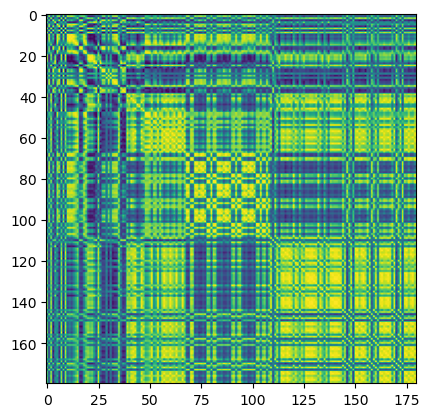

In [79]:
plt.imshow(C)

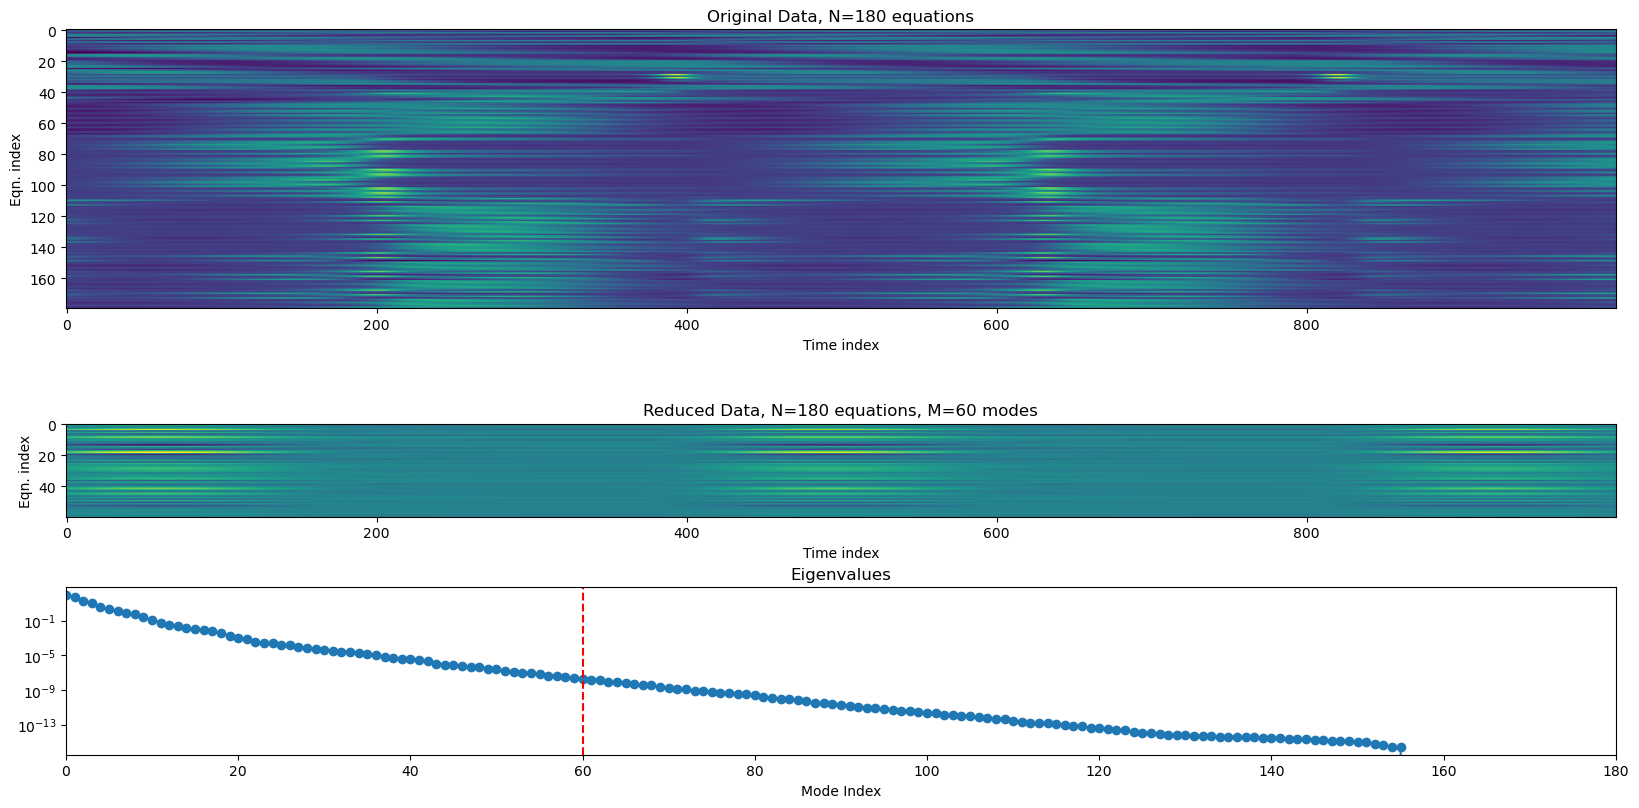

In [80]:
plots = [
    "original", 
    "reduced",
    "eigenvals",
]
fig, ax = plt.subplot_mosaic([
    [plots[0]],
    [plots[0]],
    [plots[1]],
    [plots[2]],
    ], figsize=(20, 10))
ax[plots[0]].set_title("Original Data, N={} equations".format(num_vars))
ax[plots[0]].imshow(standard_normalize(y, axis=1))
ax[plots[0]].set_xlabel("Time index")
ax[plots[0]].set_ylabel("Eqn. index")

ax[plots[1]].set_title("Reduced Data, N={} equations, M={} modes".format(num_vars, num_modes_to_keep))
ax[plots[1]].imshow(y_reduced)
ax[plots[1]].set_xlabel("Time index")
ax[plots[1]].set_ylabel("Eqn. index")

ax[plots[2]].set_xlabel("Mode Index")
ax[plots[2]].plot(pod_res.eigenvalues, marker="o")
ax[plots[2]].set_yscale("log")
ax[plots[2]].set_xlim(0, num_vars)
ax[plots[2]].set_title("Eigenvalues")
ax[plots[2]].axvline(num_modes_to_keep, color="red", linestyle="--")

## How far can we go?

In [52]:

# Example Usage (Assuming your data is in X)
num_vars, num_snapshots = y.shape

threshold = 1e-1
num_modes_to_keep = np.sum(pod_res.eigenvalues > threshold)  # Choose based on your analysis (e.g., energy threshold

pod_res_2 = pod(y, num_modes_to_keep)

# Reduced-Order Representation
y_reduced_2 = pod_res_2.projection_matrix.T @ standard_normalize(y, axis=1)  # Project onto the dominant modes


In [53]:
C_2 = pod_res_2.covariance_matrix

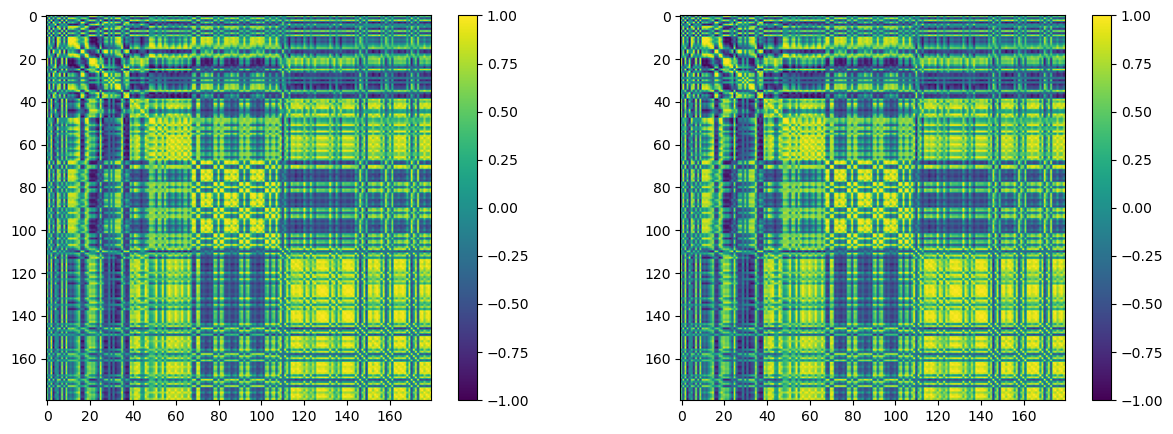

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(C)
ax[1].imshow(C_2)
fig.colorbar(ax[0].imshow(C), ax=ax[0])
fig.colorbar(ax[1].imshow(C), ax=ax[1])

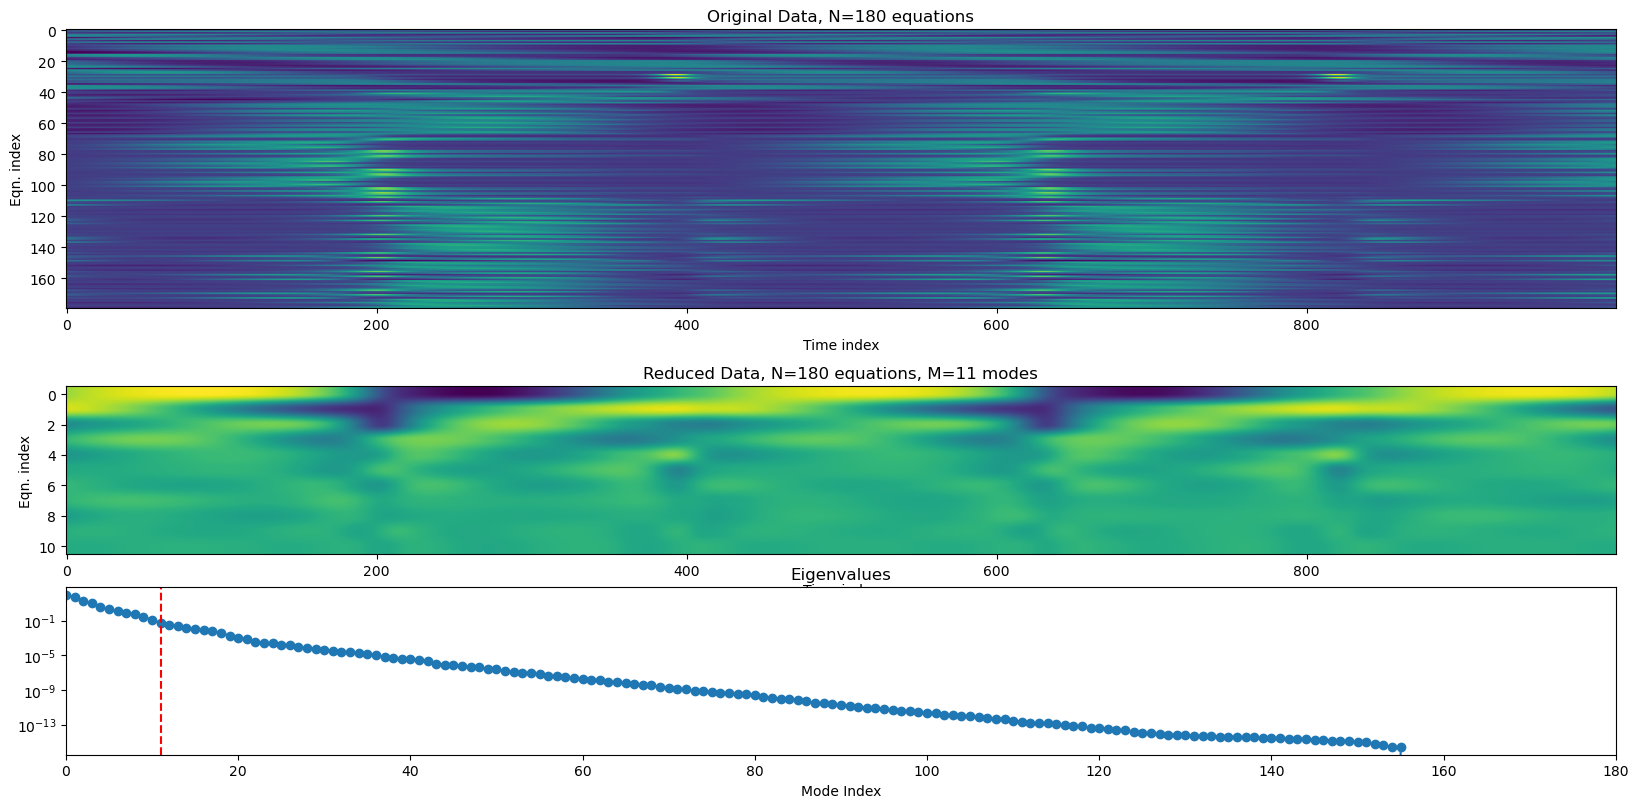

In [55]:
plots = [
    "original", 
    "reduced",
    "eigenvals",
]
fig, ax = plt.subplot_mosaic([
    [plots[0]],
    [plots[0]],
    [plots[1]],
    [plots[2]],
    ], figsize=(20, 10))
ax[plots[0]].set_title("Original Data, N={} equations".format(num_vars))
ax[plots[0]].imshow(standard_normalize(y, axis=1))
ax[plots[0]].set_xlabel("Time index")
ax[plots[0]].set_ylabel("Eqn. index")

ax[plots[1]].set_title("Reduced Data, N={} equations, M={} modes".format(num_vars, num_modes_to_keep))
ax[plots[1]].imshow(y_reduced_2, aspect="auto")
ax[plots[1]].set_xlabel("Time index")
ax[plots[1]].set_ylabel("Eqn. index")

ax[plots[2]].set_xlabel("Mode Index")
ax[plots[2]].plot(pod_res_2.eigenvalues, marker="o")
ax[plots[2]].set_yscale("log")
ax[plots[2]].set_xlim(0, num_vars)
ax[plots[2]].set_title("Eigenvalues")
ax[plots[2]].axvline(num_modes_to_keep, color="red", linestyle="--")

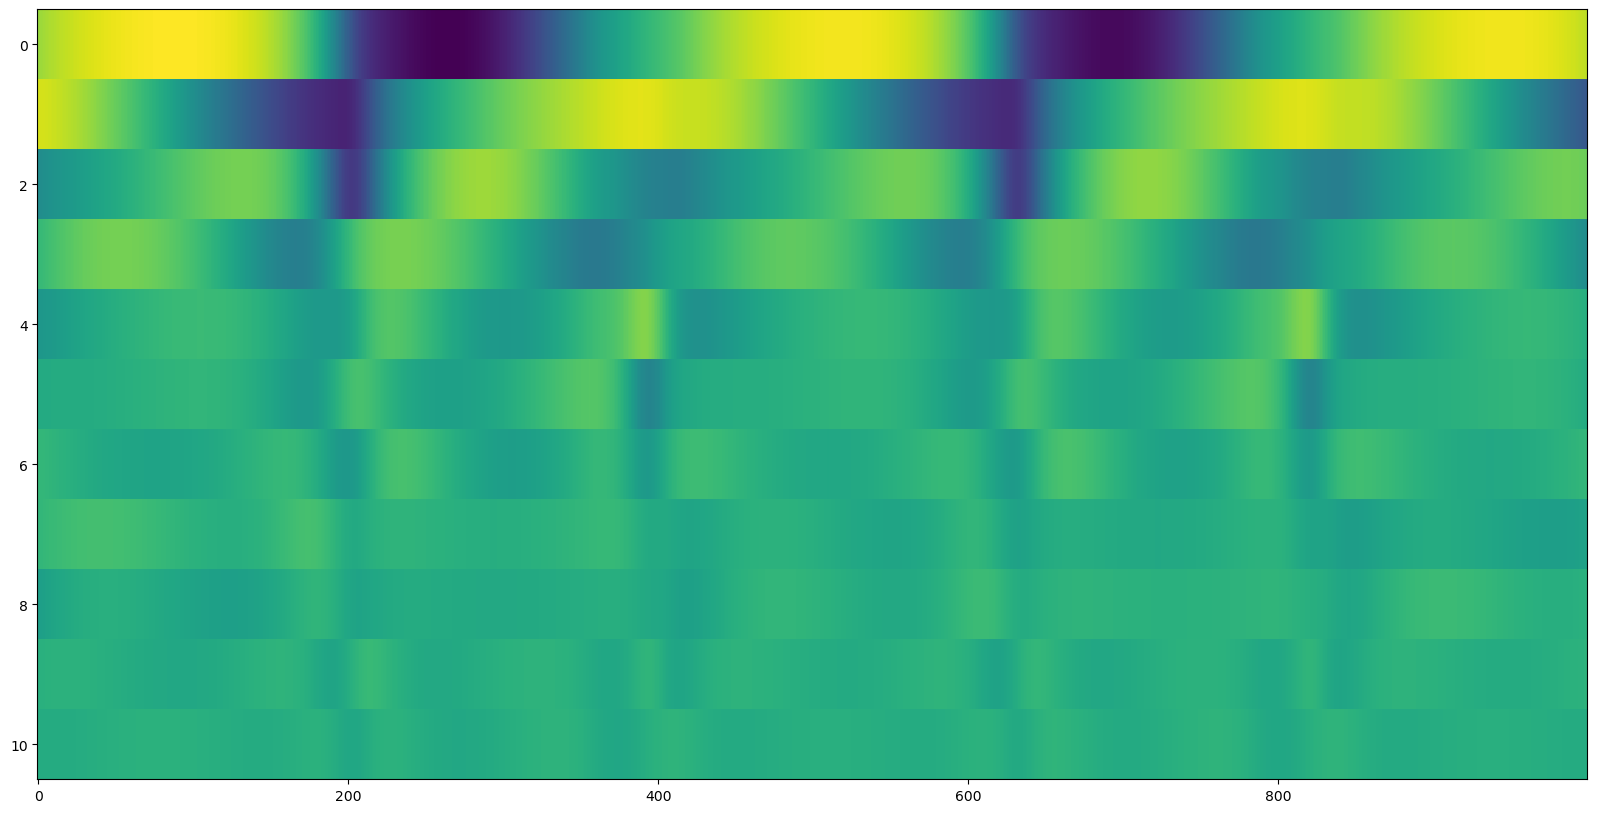

In [81]:
plt.figure(figsize=(20, 10))
plt.imshow(y_reduced_2, aspect='auto', cmap='viridis', interpolation='none')

## Fourier analysis

Text(0, 0.5, 'Amplitude')

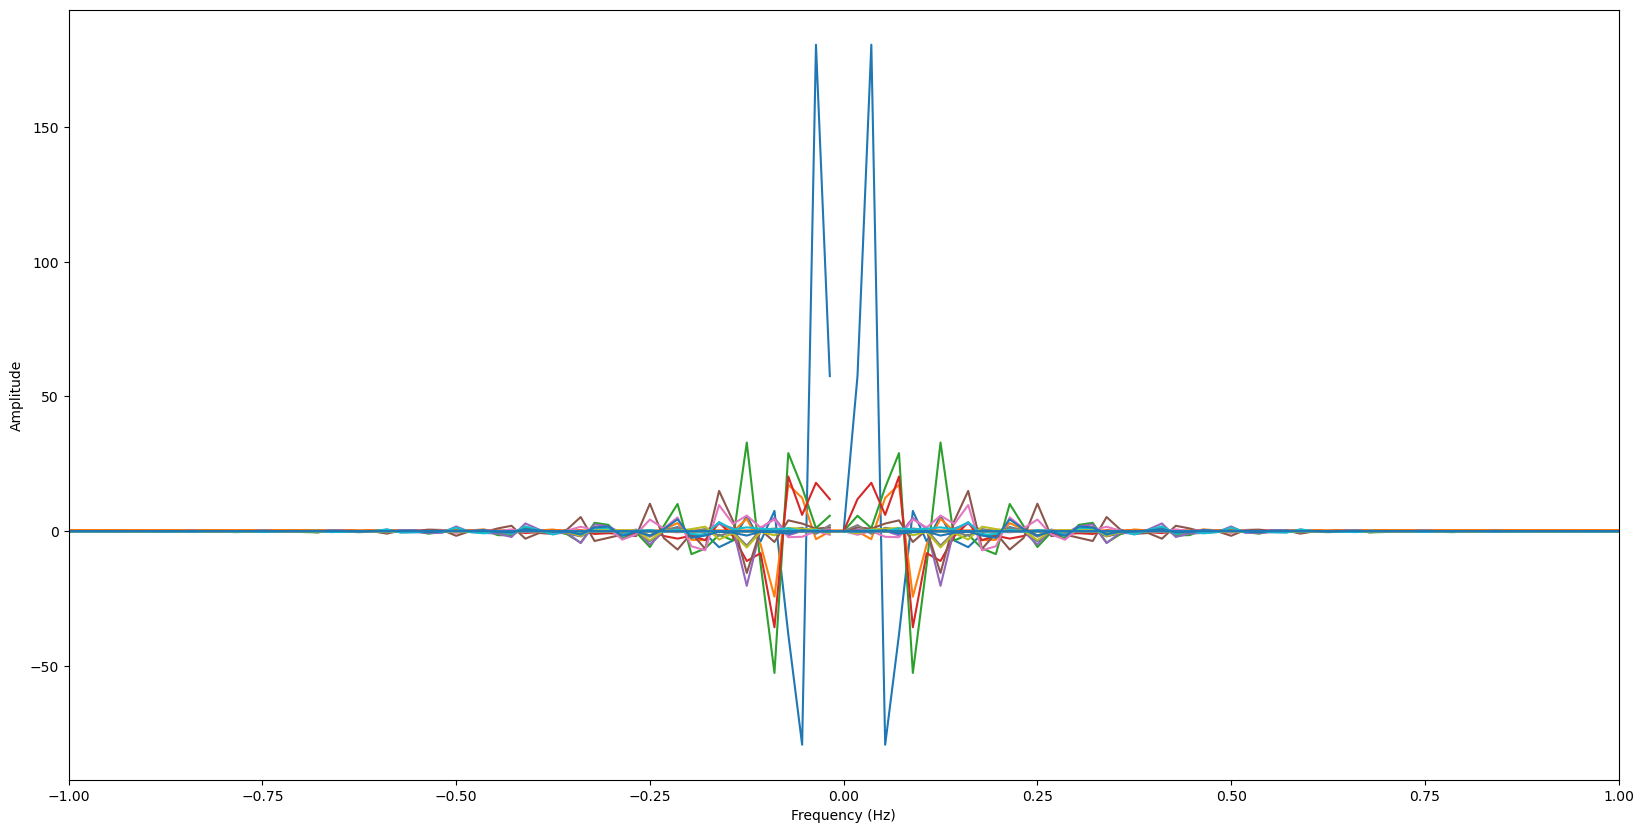

In [82]:
y_red_fft = np.fft.fft(y_reduced_2, axis=1, norm='ortho')
y_red_fft_freq = np.fft.fftfreq(y_reduced_2.shape[1], d=t_end/n_points)
plt.figure(figsize=(20, 10))
plt.plot(y_red_fft_freq, np.real(y_red_fft.T))

# plt.plot(y_red_fft_freq, np.imag(y_red_fft.T))
# plt.plot(y_red_fft_freq, np.abs(y_red_fft.T))
plt.xlim(-1, 1)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")

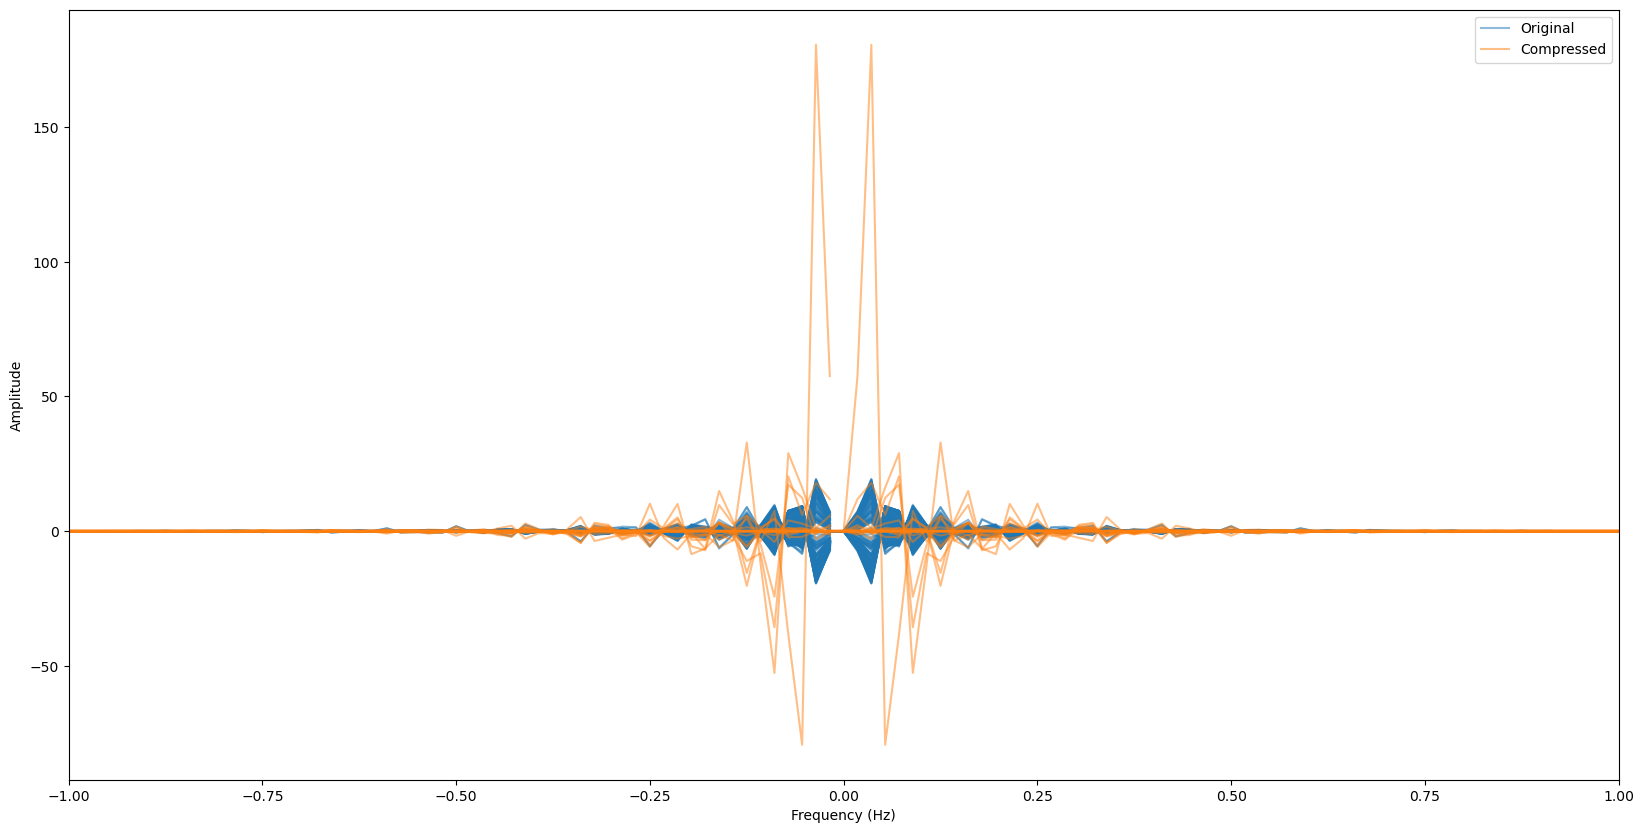

In [83]:
y_red_fft = np.fft.fft(y_reduced_2, axis=1, norm='ortho')
y_red_fft_freq = np.fft.fftfreq(y_reduced_2.shape[1], d=t_end/n_points)

y_fft = np.fft.fft(y_norm, axis=1, norm='ortho')
y_fft_freq = np.fft.fftfreq(y_norm.shape[1], d=t_end/n_points)

orig_color = 'tab:blue'
mod_color = 'tab:orange'


plt.figure(figsize=(20, 10))

plt.plot(y_fft_freq, np.real(y_fft[0].T), label='Original', alpha=0.5, color=orig_color)
for i in range(1, y_fft.shape[0]):
    plt.plot(y_fft_freq, np.real(y_fft[i]), alpha=0.5, color=orig_color)

plt.plot(y_red_fft_freq, np.real(y_red_fft[0].T), label='Compressed', alpha=0.5, color=mod_color)
for i in range(1, y_red_fft.shape[0]):
    plt.plot(y_red_fft_freq, np.real(y_red_fft[i]), alpha=0.5, color=mod_color)

plt.xlim(-1, 1)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()